In [109]:
import pandas as pd
import numpy as np

from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [ ]:
# links used

# https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb
# https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization
# https://raniyer07.medium.com/modern-portfolio-theory-using-matrix-algebra-373444327a59

In [359]:
%load_ext autoreload
%autoreload 2

In [167]:
df = pd.read_csv('project_RM.csv')
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format="%d/%m/%y")
df.columns = ['TICKER', 'DATE', 'CLOSE']

In [168]:
tickers = df['TICKER'].unique()

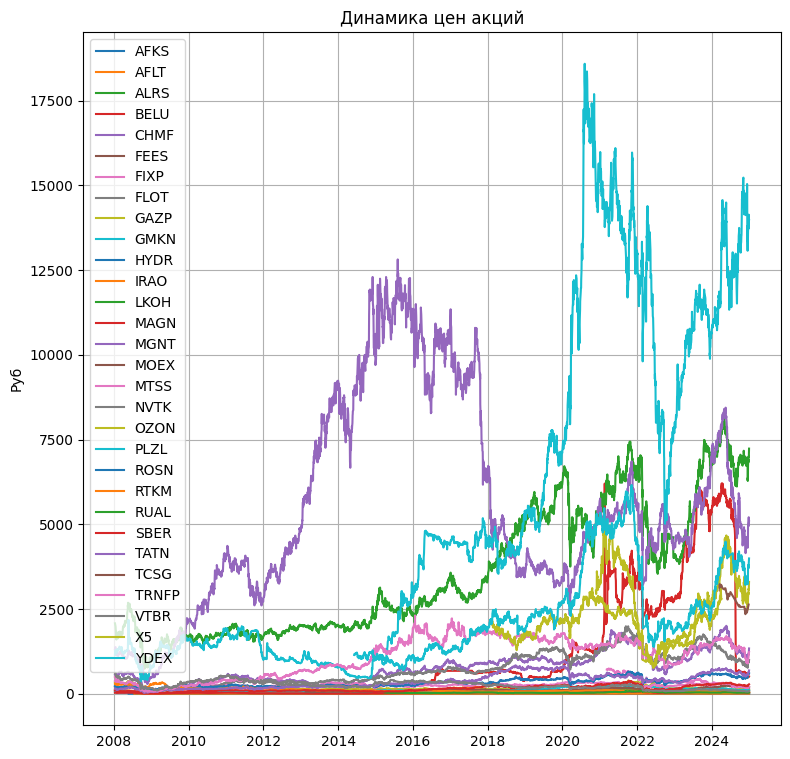

In [173]:
plt.figure(figsize = (9,9))
plt.title('Динамика цен акций')

for ticker in tickers:

    mask = df['TICKER'].eq(ticker)
    
    plt.plot(df[mask]['DATE'], df[mask]['CLOSE'], label = ticker)

plt.legend()
plt.grid()
plt.ylabel('Руб');

In [186]:
# Выбор исторического окна: 2019-12-31 по 2024-12-31
start_date = '2019-12-31'
end_date = '2024-12-31'
df_window = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

In [187]:
pivot_data = df_window.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index(ascending=True)

In [188]:
len(pivot_data)

1250

In [189]:
pivot_data.isna().sum() / len(pivot_data) * 100

TICKER
AFKS      0.00
AFLT      0.00
ALRS      0.00
BELU      0.48
CHMF      0.00
FEES      1.12
FIXP     23.92
FLOT     15.44
GAZP      0.00
GMKN      0.32
HYDR      0.00
IRAO      0.00
LKOH      0.00
MAGN      0.00
MGNT      0.00
MOEX      0.00
MTSS      0.00
NVTK      0.00
OZON     18.16
PLZL      0.00
ROSN      0.00
RTKM      0.00
RUAL      0.32
SBER      0.00
TATN      0.00
TCSG     97.52
TRNFP     0.32
VTBR      0.32
X5       15.60
YDEX      2.40
dtype: float64

/tmp/ipykernel_203352/4018163544.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pivot_data.pct_change()


Text(0, 0.5, 'daily returns')

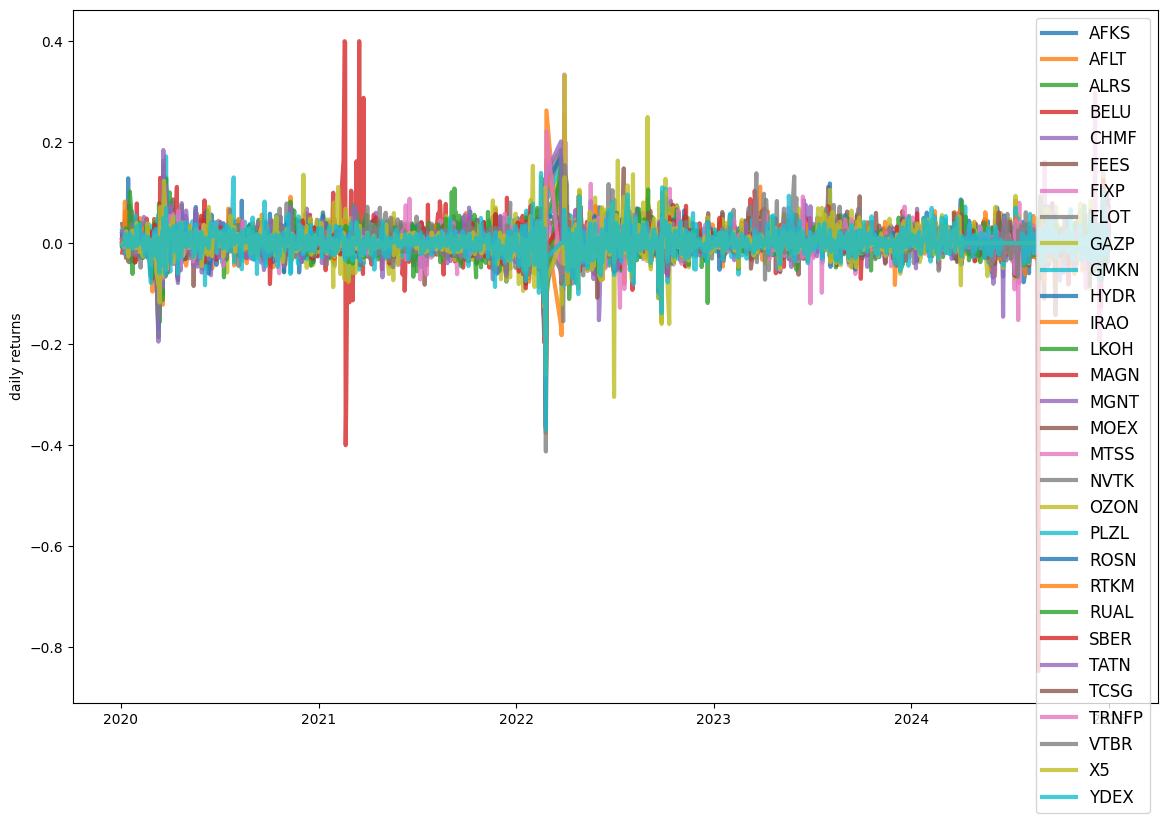

In [228]:
returns = pivot_data.pct_change()

plt.figure(figsize=(14, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

__Граница эффективности портфелей__ - combination of stocks that has the lowest risk for a given expected return

### Логика, заложенная в `frontier.py`:

Для расчета функции `portfolio_annualised_performance()` используем:

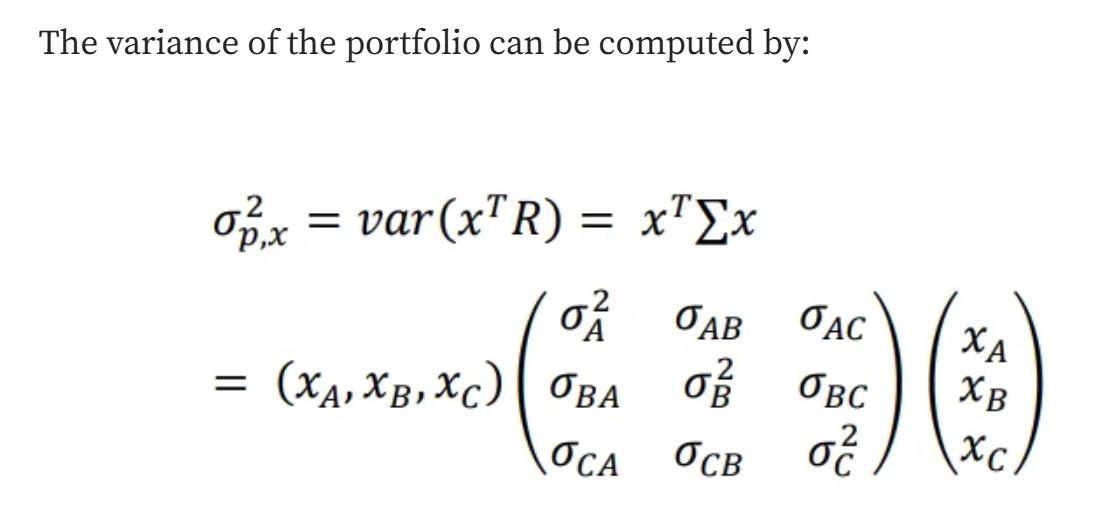

где $x_i$ -  доля инвестиций в актив i

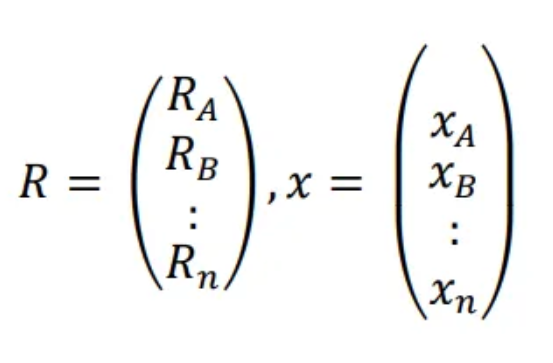

R - вектор доходностей по каждому активу
Доходность портфеля считается по формуле $return = x^TR$


Далее будем итерироваться по возможным доходностям r и подбирать такие веса для активов, чтобы минимизировать волатильность портфеля с такой доходностью.

In [367]:
returns = pivot_data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.1

/tmp/ipykernel_203352/503804025.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pivot_data.pct_change()


In [ ]:
# Выбрать схему взвешивания наблюдений для последующего расчёта границы эффективных портфелей для различных ограничений. 

num_intervals = len(returns.index.unique())
lambda_ = 0.97
weights = np.array([lambda_**(num_months - t - 1) for t in range(num_months)])
weights = weights / np.sum(weights)  # Нормировка весов

# Присвоение весов к данным
date_weights = dict(zip(returns.index.unique(), weights))

returns['w'] = returns.index.map(date_weights)

for col in returns.columns[:-1]:
    returns[col] = returns[col] * returns['w']

In [489]:
from frontier import (portfolio_annualised_performance,
                        neg_sharpe_ratio,
                        max_sharpe_ratio,
                        portfolio_volatility,
                        min_variance,
                        calculated_results,
                        efficient_return
                    )

/home/blausher/.local/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/blausher/.local/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/home/blausher/.local/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


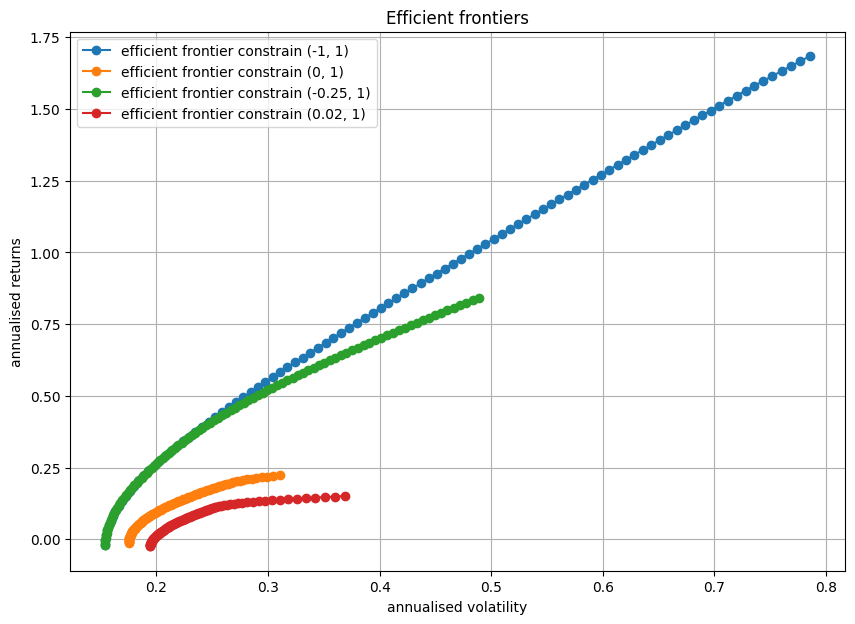

In [490]:
plt.figure(figsize=(10, 7))
plt.title(f'Efficient frontiers')

# короткие продажи разрешены без ограничений
constarin_set = (-1,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')

# короткие продажи запрещены
constarin_set = (0,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')

# доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора
constarin_set = (-0.25,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')


# 0.02% капитала должно быть вложено в каждую акцию
constarin_set = (0.02,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')


plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend()
plt.grid()